GloVe: Global Vectors for Word Representation
===================================

As discussed in the lecture, more recently prediction-based word vectors have demonstrated better performance, such as word2vec and GloVe (which also utilizes the benefit of counts). Here, we will explore the embeddings produced by GloVe. Please revisit the lecture slides for more details on the word2vec and GloVe algorithms. If you're feeling adventurous, challenge yourself and try reading [GloVe's original paper](https://nlp.stanford.edu/pubs/glove.pdf).

Run the following cells to load the GloVe vectors into memory. 

:::{note}
If this is your first time to run these cells, i.e. download the embedding model, it will take about 15 minutes to run. If you've run these cells before, rerunning them will load the model without redownloading it, which will take about 1 to 2 minutes.
:::

:::{important}
The code in this notebook is updated to work with Gensim v4.0. 
:::


In [1]:
# All Import Statements Defined Here
# Note: Do not add to this list.
# ----------------

import sys
assert sys.version_info[0]==3
assert sys.version_info[1] >= 5

from gensim.models import KeyedVectors
from gensim.test.utils import datapath
import pprint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
import nltk
nltk.download('reuters')
from nltk.corpus import reuters
import numpy as np
import random
import scipy as sp
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA

START_TOKEN = '<START>'
END_TOKEN = '<END>'

np.random.seed(0)
random.seed(0)
# ----------------

C:\ProgramData\Anaconda3\envs\cits4012\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\wei\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


In [17]:
def load_embedding_model():
    """ Load GloVe Vectors
        Return:
            wv_from_bin: All 400000 embeddings, each lengh 200
    """
    import gensim.downloader as api
    wv_pretrained = api.load("glove-wiki-gigaword-200")
    print("Loaded vocab size %i" % len(wv_pretrained))
    print("The loaded object is of type %s" % str(type(wv_pretrained)))
    return wv_pretrained

In [18]:
# -----------------------------------
# Run Cell to Load Word Vectors
# Note: This will take several minutes 
# (8 mins in my case )
# -----------------------------------
wv_pretrained = load_embedding_model()

Loaded vocab size 400000
The loaded object is of type <class 'gensim.models.keyedvectors.KeyedVectors'>


:::{important} 
Gensim 4.0 has made some significant changes to its syntax and object oragnisation. For more information see [Magrating from Gensim 3.x to 4](https://github.com/RaRe-Technologies/gensim/wiki/Migrating-from-Gensim-3.x-to-4)
:::

The `KeyedVectors` object has a dictionary property (`.key_to_index`) that returns a disctionary mapping of words to indices. 

In [22]:
{key:value for key, value in wv_pretrained.key_to_index.items() if value<10}

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9}

In [23]:
wv_pretrained.get_vector('engineering')

array([-5.1938e-02,  1.7635e-01,  1.8786e-01, -4.7958e-01,  1.0851e+00,
       -2.8156e-01, -2.8066e-02,  9.1940e-02, -7.6533e-02,  3.4757e-02,
       -5.2543e-02,  3.4220e-01, -3.3942e-01,  1.2675e-01,  3.4639e-02,
       -2.7710e-01, -1.1907e-01, -2.2184e-01,  7.1293e-01, -2.9338e-01,
       -4.2741e-01,  2.1376e+00,  1.0362e+00, -1.7944e-01,  6.5682e-01,
        5.7012e-01, -1.8262e-01,  4.5973e-01,  7.9056e-01, -8.7835e-01,
        7.9399e-01,  3.0741e-02, -1.3160e-01, -2.8041e-01,  1.3836e-01,
        4.1736e-01,  8.1038e-05, -5.7410e-01, -5.9988e-02,  1.2367e-01,
       -6.9972e-01, -3.6496e-01, -2.8456e-01, -4.4996e-01,  3.0715e-01,
       -6.0679e-01,  2.5705e-01, -3.8619e-01, -4.6077e-02, -1.7457e-01,
        3.8706e-01,  4.0831e-01, -1.7162e-01, -2.3532e-02, -3.5146e-01,
       -3.1349e-01,  2.8886e-02,  5.0182e-01,  3.4199e-01, -3.4627e-01,
        7.0743e-01,  1.5336e-01,  5.5904e-01,  4.0061e-01, -2.4110e-01,
       -3.8127e-01, -3.7064e-01,  1.1633e+00, -2.7004e-01,  3.46

#### Note: If you are receiving reset by peer error, rerun the cell to restart the download. 

## Reducing dimensionality of Word Embeddings
Let's directly compare the GloVe embeddings to those of the co-occurrence matrix. In order to avoid running out of memory, we will work with a sample of 10000 GloVe vectors instead.
Run the following cells to:

1. Put 10000 Glove vectors into a matrix M
2. Run reduce_to_k_dim (your Truncated SVD function) to reduce the vectors from 200-dimensional to 2-dimensional.

To import functions from another Jupyter notebook, we will use the `import_ipynb package`. You will need to install this into your environment.
'''
pip install import_ipynb
'''

In [25]:
def get_matrix_of_vectors(wv_pretrained, required_words=['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']):
    """ Put the GloVe vectors into a matrix M.
        Param:
            wv_pretrained: KeyedVectors object; the 400000 GloVe vectors loaded from file
        Return:
            M: numpy matrix shape (num words, 200) containing the vectors
            word2Ind: dictionary mapping each word to its row number in M
    """
    import random
    words = list(wv_pretrained.key_to_index.keys())
    print("Shuffling words ...")
    random.seed(224)
    random.shuffle(words)
    words = words[:10000]
    print("Putting %i words into word2Ind and matrix M..." % len(words))
    word2Ind = {}
    M = []
    curInd = 0
    for w in words:
        try:
            M.append(wv_pretrained.get_vector(w, norm=True))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    for w in required_words:
        if w in words:
            continue
        try:
            M.append(wv_pretrained.get_vector(w, norm=True))
            word2Ind[w] = curInd
            curInd += 1
        except KeyError:
            continue
    M = np.stack(M)
    print("Done.")
    return M, word2Ind

importing Jupyter notebook from svd.ipynb


[nltk_data] Downloading package reuters to
[nltk_data]     C:\Users\wei\AppData\Roaming\nltk_data...
[nltk_data]   Package reuters is already up-to-date!


[['<START>', 'japan', 'to', 'revise', 'long', '-', 'term', 'energy', 'demand', 'downwards', 'the',
  'ministry', 'of', 'international', 'trade', 'and', 'industry', '(', 'miti', ')', 'will', 'revise',
  'its', 'long', '-', 'term', 'energy', 'supply', '/', 'demand', 'outlook', 'by', 'august', 'to',
  'meet', 'a', 'forecast', 'downtrend', 'in', 'japanese', 'energy', 'demand', ',', 'ministry',
  'officials', 'said', '.', 'miti', 'is', 'expected', 'to', 'lower', 'the', 'projection', 'for',
  'primary', 'energy', 'supplies', 'in', 'the', 'year', '2000', 'to', '550', 'mln', 'kilolitres',
  '(', 'kl', ')', 'from', '600', 'mln', ',', 'they', 'said', '.', 'the', 'decision', 'follows',
  'the', 'emergence', 'of', 'structural', 'changes', 'in', 'japanese', 'industry', 'following',
  'the', 'rise', 'in', 'the', 'value', 'of', 'the', 'yen', 'and', 'a', 'decline', 'in', 'domestic',
  'electric', 'power', 'demand', '.', 'miti', 'is', 'planning', 'to', 'work', 'out', 'a', 'revised',
  'energy', 'supply

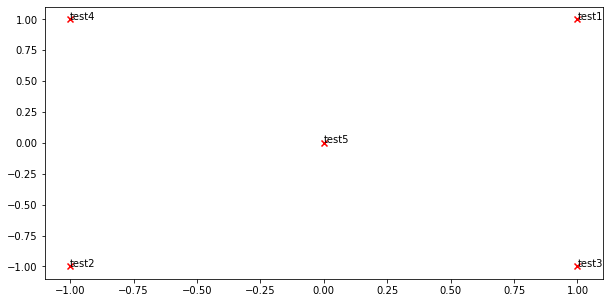

--------------------------------------------------------------------------------
Shuffling words ...
Putting 10000 words into word2Ind and matrix M...
Done.
Running Truncated SVD over 10010 words...
Done.


In [27]:
import import_ipynb
from svd import reduce_to_k_dim

# -----------------------------------------------------------------
# Run Cell to Reduce 200-Dimensional Word Embeddings to k Dimensions
# Note: This should be quick to run
# -----------------------------------------------------------------
M, word2Ind = get_matrix_of_vectors(wv_pretrained)
M_reduced = reduce_to_k_dim(M, k=2)

# Rescale (normalize) the rows to make them each of unit-length
M_lengths = np.linalg.norm(M_reduced, axis=1)
M_reduced_normalized = M_reduced / M_lengths[:, np.newaxis] # broadcasting

:::{note} 
If you are receiving out of memory issues on your local machine, try closing other applications to free more memory on your device. You may want to try restarting your machine so that you can free up extra memory. Then immediately run the jupyter notebook and see if you can load the word vectors properly. 
:::


## GloVe Plot Analysis

Run the cell below to plot the 2D GloVe embeddings for `['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']`.

What clusters together in 2-dimensional embedding space? What doesn't cluster together that you might think should have? How is the plot different from the one generated earlier from the co-occurrence matrix? What is a possible reason for causing the difference?

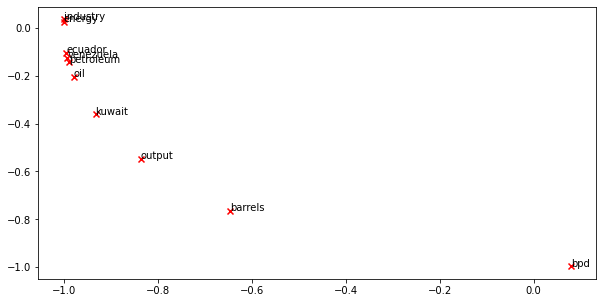

In [29]:
from svd import plot_embeddings

words = ['barrels', 'bpd', 'ecuador', 'energy', 'industry', 'kuwait', 'oil', 'output', 'petroleum', 'venezuela']
plot_embeddings(M_reduced_normalized, word2Ind, words)